#K-Nearest Neighbors
Jose Alberto Gonzalez Arteaga A01038061


In [296]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from graphviz import Source
from sklearn.tree import export_graphviz
from matplotlib.colors import ListedColormap


In [297]:
#Configs dirs for images
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID,)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [298]:
#save fig functions on the directory
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

In [299]:
#predict value depends of the k nearest neighbors, return max predicted value
def predict(df, y, k):
  nsmallest = df.nsmallest(k, 'diff_values_x_to_predict')
  index_smallest = list(nsmallest.index.values)
  pred = []
  for i in index_smallest:
    pred.append(y.loc[i])
  return max(pred)

#diff function for the operation |(Xi - yi)|^p
def diff(x, y, p):
  return pow(abs(x-y), p)

#chebyshev distance
def chebyshev(X, x_test):
  diffs = []
  for i in range(len(X)):
    diffs.append(abs(X[i] - x_test[i]))
  return max(diffs)

#K-Nearest Neighbors with Minkowski
def minkowski(X, x_test, p):
  # if(p==np.inf):
  #   return chebyshev(X, x_test)
  # else: 
    #Manage ndarray
    X = np.array(X)
    x_test = np.array(x_test)
    dist_history = []

    #Minkowski formula
    for x in X:
      dist = sum(diff(x, x_test, p))
      dist = pow(dist, (1/p))
      dist_history.append(dist)
    return dist_history

In [300]:
#Batch Gradient Descent Algorithm
def sigmoid(x):
  return 1.0 / (1 + np.exp(-x))

def lr_hypothesis(x, theta):
  return np.dot(x,theta)

#return hb_opt => 
def batchGradientDescent(X, y, b0 = 0.5, ALPHA = 0.25, max_it=5000, 
                         threshold = 1 * pow(10,-4)):
  #prepare data
  X = X.values
  y = y.values
  
  zm, zn = X.shape
  z = np.ones(zm)
  z = z.reshape(zm, 1)
  X = np.append(z,X,axis=1)

  m, n = X.shape
  theta = np.zeros(n)
  theta = theta.reshape(n,1)
  y = y.reshape(-1,1)
  diff = 1
  j = 0
  
  while j < max_it and diff > threshold:
    last_t = theta
    infunc1 = sigmoid(lr_hypothesis(X, theta)) - y
    gradient = np.dot(X.T, infunc1) / m
    theta = theta - (ALPHA / m) * gradient
    diff = np.linalg.norm(last_t-theta)
    j+=1
  return theta, j

In [301]:
#Testing functions for logistic Regression

#return if classify in 1 or 0.
def logistic_classify(x):
  return int(x > 0.5)

#compare data
def logistic_compare(y_hat, y):
  return np.where(y_hat == y, 0, 1)

#return error
def logistic_error(y_hat, y, T):
  return 1 / T * sum(logistic_compare(y_hat, y))

#Apply model with values to predict probability of 1.
def logistic_predict(model, X):
  X = X.values
  X = np.insert(X, 0, 1.0)
  return sigmoid(np.dot(model.T, X))


In [302]:
#Test functions

#compare data
def compare(y_hat, y):
  return np.where(y_hat == y, 0, 1)

#return error
def get_error(y_hat, y, T):
  return 1 / T * sum(compare(y_hat, y))

## Gender dataset
Gender dataset classify if is Male or Female considering next args:
* Weight
* Height


In [303]:
#read data
gender_data = pd.read_csv("Gender.txt")

In [304]:
gender_data.sample(5)

,Gender,Height,Weight
6317,Female,62.656619,123.870494
1337,Male,72.673994,206.980218
9921,Female,67.178270,166.601377
317,Male,69.380995,199.850920
864,Male,70.916552,191.883267


In [305]:
gender_data.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


### Preprocessing data (gender dataset)

In [306]:
#Change categorical variable to numerical.
gender_data = pd.get_dummies(gender_data, columns=['Gender'])
del gender_data['Gender_Male']
gender_data.head()

,Height,Weight,Gender_Female
0,73.847017,241.893563,0
1,68.781904,162.310473,0
2,74.110105,212.740856,0
3,71.730978,220.042470,0
4,69.881796,206.349801,0


In [307]:
# Split in train / test data
# X => Gender_Female => (Male=0, Female=1)
# y => (Height, Weight) 
X = gender_data[['Height','Weight']]
y = gender_data['Gender_Female']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Minkowski algorithm (Genderdata)

In [308]:
#Minkowski Algorithm
x_predict = X_test.values #value to predict
p = [1,2,np.inf] #p values for minkowski algorith
k = [1,2,3,5,10,15,20,25,50,100] #number of neighbors 

df_genderResults = pd.DataFrame(columns=['p','k', 'error'])

for ip in p:
  for ik in k:
    y_predict = []
    for to_predict in x_predict:
      dist = minkowski(X_train, to_predict, ip)
      df = X_train.copy()
      df.insert(2,"diff_values_x_to_predict", dist)
      y_predict.append(predict(df,y,ik))
    y_predict = pd.Series((y_predict))
    error = 1 - get_error(y_predict.values, y_test.values, y_predict.size)
    new_row = {'p': ip, 'k': ik, 'error':error }
    df_genderResults = df_genderResults.append(new_row, ignore_index=True)

In [309]:
#Find best results in df_genderResults
df_genderResults

,p,k,error
0,1.0,1.0,0.8815
1,1.0,2.0,0.8850
2,1.0,3.0,0.8705
3,1.0,5.0,0.8450
4,1.0,10.0,0.8065
5,1.0,15.0,0.7785
6,1.0,20.0,0.7615
7,1.0,25.0,0.7440
8,1.0,50.0,0.7100
9,1.0,100.0,0.6640


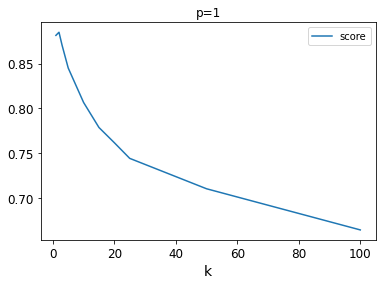

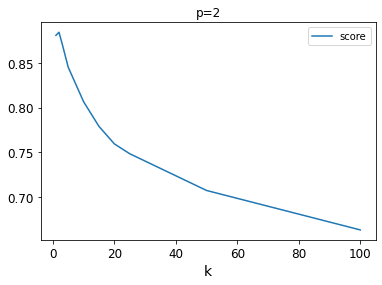

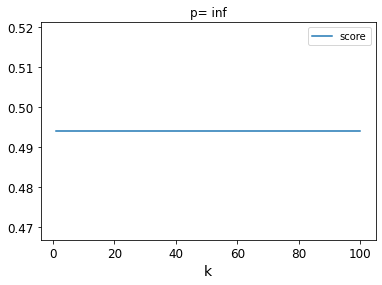

In [310]:
#k vs score values
p1_score = df_genderResults[df_genderResults.p == 1]
p2_score = df_genderResults[df_genderResults.p == 2]
pinf_score = df_genderResults[df_genderResults.p == np.inf]

#plot 3 graphs of k vs score
p1_score.plot(x ='k', y='error', kind = 'line')
plt.legend(["score"])
plt.title('p=1')
p2_score.plot(x ='k', y='error', kind = 'line')
plt.legend(["score"])
plt.title('p=2')
pinf_score.plot(x ='k', y='error', kind = 'line')
plt.legend(["score"])
plt.title('p= inf')
plt.show()

In [311]:
#Identify best k value with highest score.
best_k = int(df_genderResults.iloc[df_genderResults['error'].argmax()].k)
best_k

2

### Sklearn K-nearestNeighbors model (gender dataset)

In [312]:
#NearestNeighbors model Sklearn with best k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
model.fit(X_train, y_train)
Nearest_predict = model.predict(X_test)
model.score(X_test, y_test)

0.877

### Logistic Regression (gender dataset)

In [313]:
#train model
#parms:
# X => X_train model data
# y => y_train model data
print('Gender dataset: batch Gradient Descent Algorithm')
b_init = 0.5 # float(input('Give value of beta init (0,1): '))
ALPHA = 0.5 # float(input('Give value of ALPHA (0,1): '))
max_it = 1000 # int(input('Give value of the limit of iterations: '))
threshold = 0.0001 # float(input('Give value of threshold (ex. 0.0001): '))
model, j = batchGradientDescent(X_train, y_train, b_init, ALPHA, max_it, threshold)
print('B vector: ')
print(model)
print('iterations: ', j)

Gender dataset: batch Gradient Descent Algorithm
B vector: 
[[ 0.00223863]
 [ 0.10653908]
 [-0.04477251]]
iterations:  784


In [314]:
#Test model

#predict values
y_predicted_value = X_test.apply(lambda x: logistic_predict(model, x), axis=1)
#Classify values
y_predicted = y_predicted_value.apply(logistic_classify)
#error
print('error: ', 1-logistic_error(y_predicted, y_test, y_predicted.size))

error:  0.9145


### Decision Tree (Gender dataset)

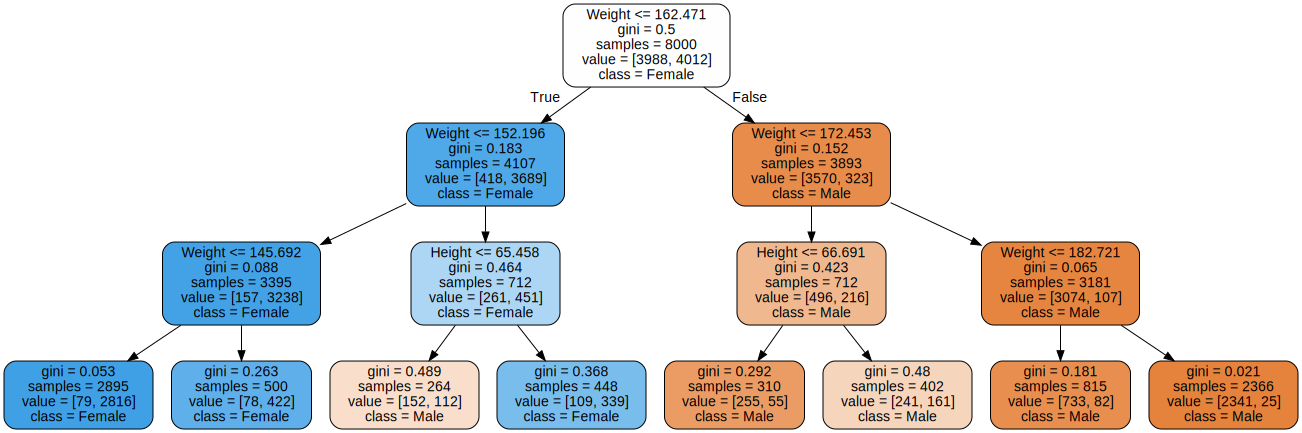

In [315]:
#Decision tree fit with the training data
tree_clf = DecisionTreeClassifier(max_depth = 3, random_state=0)
tree_clf = tree_clf.fit(X_train, y_train)

#Create tree view
export_graphviz(
    tree_clf,
    out_file = os.path.join(IMAGES_PATH, "gender.dot"),
    feature_names = ["Height", "Weight"],
    class_names = ["Male", "Female"],
    rounded=True,
    filled=True
)

Source.from_file(os.path.join(IMAGES_PATH, "gender.dot"))

In [316]:
#Calculate Accuracy: correct predictions / total number of data points
score = tree_clf.score(X_test, y_test)
tree_pred = tree_clf.predict(X_test)
print("Score of gender dataset with Decision tree model: ", score)

Score of gender dataset with Decision tree model:  0.9105


### Graphics (Gender dataset):


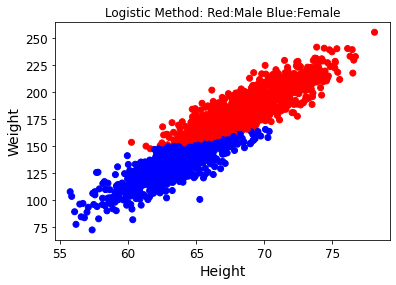

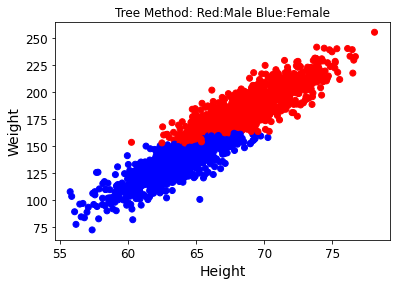

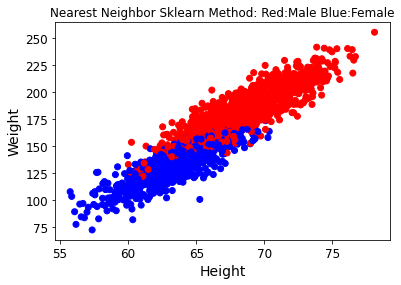

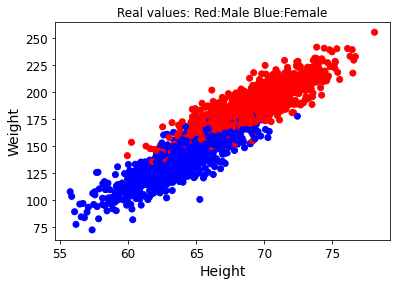

In [317]:
#weigth vs height graphic 
#Compare classification with 3 methods

# Logistic method
plt.title('Logistic Method: Red:Male Blue:Female')
c = ["b" if y == 1 else "r" for y in y_predicted]
plt.scatter(X_test[['Height']],X_test[['Weight']],c=c)
plt.ylabel('Weight')
plt.xlabel('Height')
plt.show()

# Tree method
plt.title('Tree Method: Red:Male Blue:Female')
c = ["b" if y == 1 else "r" for y in tree_pred]
plt.scatter(X_test[['Height']],X_test[['Weight']],c=c)
plt.ylabel('Weight')
plt.xlabel('Height')
plt.show()

# Tree method
plt.title('Nearest Neighbor Sklearn Method: Red:Male Blue:Female')
c = ["b" if y == 1 else "r" for y in Nearest_predict]
plt.scatter(X_test[['Height']],X_test[['Weight']],c=c)
plt.ylabel('Weight')
plt.xlabel('Height')
plt.show()

#Real values
plt.title('Real values: Red:Male Blue:Female')
c = ["b" if y == 1 else "r" for y in y_test]
plt.scatter(X_test[['Height']],X_test[['Weight']],c=c)
plt.ylabel('Weight')
plt.xlabel('Height')
plt.show()


## Credit dataset
Credit Card Default dataset Identify if the user will pay the credit card considering next parms:

* ID: Customer id.
* Default: Yes/No if the customer will pay.
* Student: Yes/No if the customer is student.
* Balance: Average money in the credit card after their monthly pay.
* Income: Income of the customer.

In [341]:
# #read data
credit_data = pd.read_csv("Default.txt", sep='\t')

### Preprocessing data (credit dataset)

In [342]:
# #Change categorical variable to numerical.
credit_data = pd.get_dummies(credit_data, columns=['student', 'default'])
del credit_data['student_No']
del credit_data['default_No']
credit_data.head()

,balance,income,student_Yes,default_Yes
1,729.526495,44361.625074,0,0
2,817.180407,12106.134700,1,0
3,1073.549164,31767.138947,0,0
4,529.250605,35704.493935,0,0
5,785.655883,38463.495879,0,0


In [343]:
# # Split in train / test data
# # X => Gender_Female => (Male=0, Female=1)
# # y => (Height, Weight) 
X = credit_data[['student_Yes','balance', 'income']]
y = credit_data['default_Yes']
t_size = 0.2 #float(input('Give value of split test size (ex. 0.2): '))
rand_num = 42 # int(input('Give value of initial random generator: '))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size, random_state=rand_num)

### Minkowski algorith (credit data)

In [321]:
#Minkowski Algorithm
x_predict = X_test.values #value to predict
p = [1,2,np.inf] #p values for minkowski algorith
k = [1,2,3,5,10,15,20,25,50,100] #number of neighbors 

df_creditResults = pd.DataFrame(columns=['p','k', 'error'])

for ip in p:
  for ik in k:
    y_predict = []
    for to_predict in x_predict:
      dist = minkowski(X_train, to_predict, ip)
      df = X_train.copy()
      df.insert(2,"diff_values_x_to_predict", dist)
      y_predict.append(predict(df,y,ik))
    y_predict = pd.Series((y_predict))
    error = 1 - get_error(y_predict.values, y_test.values, y_predict.size)
    new_row = {'p': ip, 'k': ik, 'error':error }
    df_creditResults = df_creditResults.append(new_row, ignore_index=True)

In [322]:
df_creditResults

,p,k,error
0,1.0,1.0,0.9490
1,1.0,2.0,0.9405
2,1.0,3.0,0.9275
3,1.0,5.0,0.9120
4,1.0,10.0,0.8735
5,1.0,15.0,0.8375
6,1.0,20.0,0.8130
7,1.0,25.0,0.7935
8,1.0,50.0,0.6955
9,1.0,100.0,0.5270


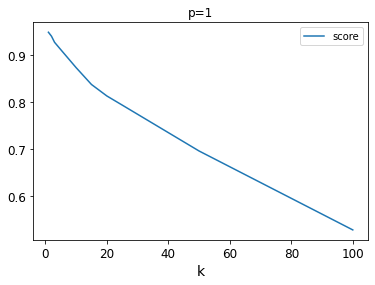

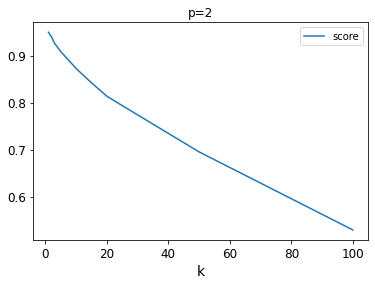

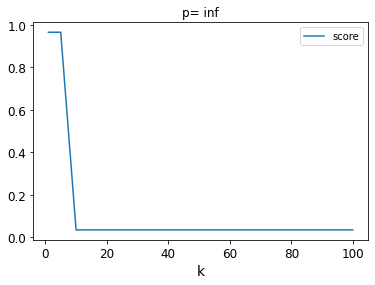

In [323]:
#k vs score values
p1_score = df_creditResults[df_creditResults.p == 1]
p2_score = df_creditResults[df_creditResults.p == 2]
pinf_score = df_creditResults[df_creditResults.p == np.inf]

#plot 3 graphs of k vs score
p1_score.plot(x ='k', y='error', kind = 'line')
plt.legend(["score"])
plt.title('p=1')
p2_score.plot(x ='k', y='error', kind = 'line')
plt.legend(["score"])
plt.title('p=2')
pinf_score.plot(x ='k', y='error', kind = 'line')
plt.legend(["score"])
plt.title('p= inf')
plt.show()

In [344]:
#Identify best k value with highest score.
best_k = int(df_creditResults.iloc[df_creditResults['error'].argmax()].k)
best_k

1

### Sklearn K-nearestNeighbors model (credit dataset)

In [345]:
#NearestNeighbors model Sklearn with best k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9495

### Logistic Regression (credit dataset)

In [352]:
#train model
#parms:
# X => X_train model data
# y => y_train model data
print('credit dataset: batch Gradient Descent Algorithm')
b_init = 0.5 # float(input('Give value of beta init (0,1): '))
ALPHA = 0.005 # float(input('Give value of ALPHA (0,1): '))
max_it = 1000 # int(input('Give value of the limit of iterations: '))
threshold = 0.0001 # float(input('Give value of threshold (ex. 0.0001): '))
model, j = batchGradientDescent(X_train, y_train, b_init, ALPHA, max_it, threshold)
print('B vector: ')
print(model)
print('iterations: ', j)

credit dataset: batch Gradient Descent Algorithm
<ipython-input-300-47b5e52df912>:3: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))
B vector: 
[[ 1.94829046e-07]
 [ 5.16714535e-07]
 [ 4.13826389e-03]
 [-3.08884813e-04]]
iterations:  211


In [353]:
#Test model

#predict values
y_predicted_value = X_test.apply(lambda x: logistic_predict(model, x), axis=1)
#Classify values
y_predicted = y_predicted_value.apply(logistic_classify)
#error
print('error: ', 1-logistic_error(y_predicted, y_test, y_predicted.size))

error:  0.896


### Decision Tree (credit dataset)

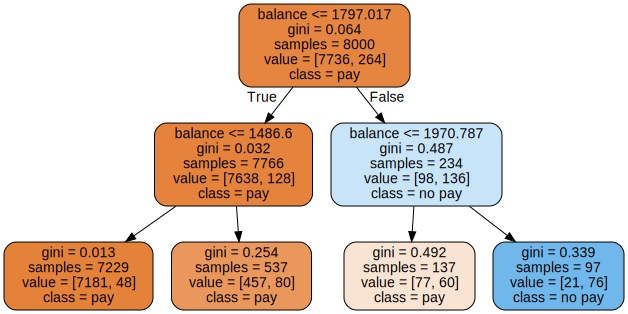

In [328]:
#Decision tree fit with the training data
tree_clf = DecisionTreeClassifier(max_depth = 2, random_state=0)
tree_clf = tree_clf.fit(X_train, y_train)

#Create tree view
export_graphviz(
    tree_clf,
    out_file = os.path.join(IMAGES_PATH, "credit.dot"),
    feature_names = ["student_Yes", "balance", "income"],
    class_names = ["pay", "no pay"],
    rounded=True,
    filled=True
)

Source.from_file(os.path.join(IMAGES_PATH, "credit.dot"))

In [329]:
#Calculate Accuracy: correct predictions / total number of data points
score = tree_clf.score(X_test, y_test)
print("Score of gender dataset with Decision tree model: ", score)

Score of gender dataset with Decision tree model:  0.968


## iris dataset

In [354]:
#import dataset and transform to csv
from sklearn.datasets import load_iris
iris = load_iris()
iris_data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

In [355]:
# # Split in train / test data
X = iris_data[['sepal length (cm)','sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = iris_data['target']
t_size = 0.2 #float(input('Give value of split test size (ex. 0.2): '))
rand_num = 42 # int(input('Give value of initial random generator: '))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size, random_state=rand_num)

### Minkowski Algorithm

In [332]:
#Minkowski Algorithm
x_predict = X_test.values #value to predict
p = [1,2,np.inf] #p values for minkowski algorith
k = [1,2,3,5,10,15,20,25,50,100] #number of neighbors 

df_irisResults = pd.DataFrame(columns=['p','k', 'error'])

for ip in p:
  for ik in k:
    y_predict = []
    for to_predict in x_predict:
      dist = minkowski(X_train, to_predict, ip)
      df = X_train.copy()
      df.insert(2,"diff_values_x_to_predict", dist)
      y_predict.append(predict(df,y,ik))
    y_predict = pd.Series((y_predict))
    error = 1 - get_error(y_predict.values, y_test.values, y_predict.size)
    new_row = {'p': ip, 'k': ik, 'error':error }
    df_irisResults = df_irisResults.append(new_row, ignore_index=True)

In [333]:
df_irisResults

,p,k,error
0,1.0,1.0,1.000000
1,1.0,2.0,0.966667
2,1.0,3.0,0.966667
3,1.0,5.0,0.933333
4,1.0,10.0,0.833333
5,1.0,15.0,0.833333
6,1.0,20.0,0.833333
7,1.0,25.0,0.800000
8,1.0,50.0,0.366667
9,1.0,100.0,0.366667


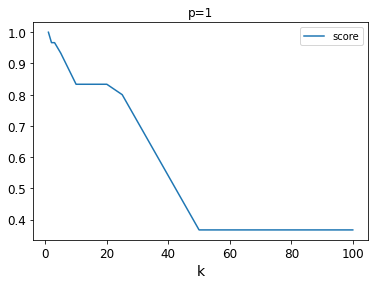

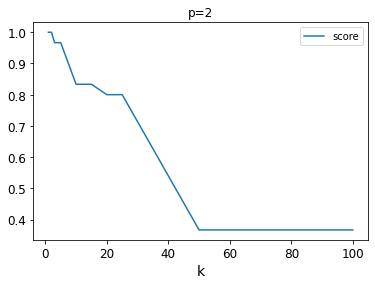

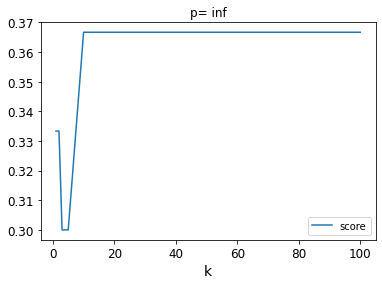

In [334]:
#k vs score values
p1_score = df_irisResults[df_irisResults.p == 1]
p2_score = df_irisResults[df_irisResults.p == 2]
pinf_score = df_irisResults[df_irisResults.p == np.inf]

#plot 3 graphs of k vs score
p1_score.plot(x ='k', y='error', kind = 'line')
plt.legend(["score"])
plt.title('p=1')
p2_score.plot(x ='k', y='error', kind = 'line')
plt.legend(["score"])
plt.title('p=2')
pinf_score.plot(x ='k', y='error', kind = 'line')
plt.legend(["score"])
plt.title('p= inf')

plt.show()

In [335]:
#Identify best k value with highest score.
best_k = int(df_irisResults.iloc[df_irisResults['error'].argmax()].k)
best_k

1

### Sklearn K-nearestNeighbors model (iris dataset)

In [336]:
#NearestNeighbors model Sklearn with best k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
model.fit(X_train, y_train)
model.score(X_test, y_test)

1.0

### Logistic Regression (iris dataset)

In [409]:
#train model
#parms:
# X => X_train model data
# y => y_train model data
print('iris dataset: batch Gradient Descent Algorithm')
b_init = 0.5 # float(input('Give value of beta init (0,1): '))
ALPHA = 0.05 # float(input('Give value of ALPHA (0,1): '))
max_it = 1000 # int(input('Give value of the limit of iterations: '))
threshold = 0.00001 # float(input('Give value of threshold (ex. 0.0001): '))
model, j = batchGradientDescent(X_train, y_train, b_init, ALPHA, max_it, threshold)
print('B vector: ')
print(model)
print('iterations: ', j)

iris dataset: batch Gradient Descent Algorithm
B vector: 
[[0.03448436]
 [0.40116465]
 [0.04119869]
 [0.66134915]
 [0.27084664]]
iterations:  1000


In [410]:
#Test model

#predict values
y_predicted_value = X_test.apply(lambda x: logistic_predict(model, x), axis=1)
#Classify values
y_predicted = y_predicted_value.apply(logistic_classify)
#error
print('error: ', 1-logistic_error(y_predicted, y_test, y_predicted.size))

error:  0.30000000000000004


### Decision Tree (iris dataset)

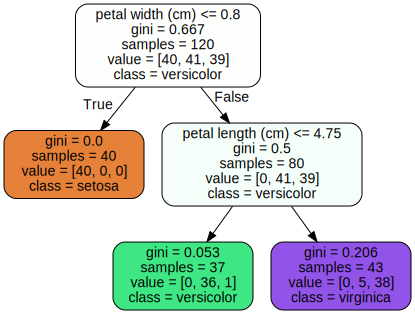

In [339]:
#Decision tree fit with the training data
tree_clf = DecisionTreeClassifier(max_depth = 2, random_state=0)
tree_clf = tree_clf.fit(X_train, y_train)

#Create tree view
export_graphviz(
    tree_clf,
    out_file = os.path.join(IMAGES_PATH, "iris_tree.dot"),
    feature_names = iris.feature_names,
    class_names = iris.target_names,
    rounded=True,
    filled=True
)

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

In [340]:
#Calculate Accuracy: correct predictions / total number of data points
score = tree_clf.score(X_test, y_test)
print("Score of iris dataset with Decision tree model: ", score)

Score of iris dataset with Decision tree model:  0.9666666666666667
